# Multi-Target Tracking with GM-PHD Filter

This is a series of tutorials for my research that apply GM-PHD multi-target tracking for multi-resident tracking problem in smart homes.

In this first tutorial, I will explain GM-PHD filter, and demonstrate it with synthetic data generated by a 2D constant velocity model with Gaussian noise.

# Part I: 2D Synthetic Data Generation

To demonstrate the performance of GMPHD filter, we first generate some synthetic data simulating multiple targets moving at almost constant velocity in a 2D space (easier for illustration).

In a multi-target environment, we have more issues to consider in additional to the mobility model of each target (constant velocity model in this case).
Those include when and where each target is born, how long each taget persists, the variation between position measurement and the actual location of each target, and noisy measurements caused by the clutter process (i.e. false alarms/false measurements).

In this synthetic data generation, each target is assumed to be moving at a constant velocity with some variance to the target velocity and the location measurement of each target.
Such variance is modeled as a Gaussian error.

In [1]:
import numpy as np
from smrt.synthetic import CvMTGM_ID_Model

## Measurement Space and State Space

In this simulation, each target is a point moving at constant velocity in a 2-dimensional space, the measurement ($\mathbf{z}$) of each target is a $2\times1$ vector, and the target state $\mathbf{x}=\begin{bmatrix}x&y&v_x&v_y&t\end{bmatrix}^T$, is a $5\times1$ vector, where $x$, $y$ are its position in the space, $v_x$ and $v_y$ are the velocities of the target along each dimension, and $t$ is the target identifier, or the track identifier.

In [2]:
# Define the dimension of visible measurement space
n_visible = 2

## Initial States of Targets

In this simulation, we assume that there are 12 targets.
The initial state of each target is defined in the code below.
For example, the target $0$ starts at position $(0, 0)$ with a velocity of $(0, -10)$ per time step.

In [3]:
# 12 targets, 2D Constant Velocity Model
n_targets = 12

x_init = np.zeros((n_targets, 4))
x_init[ 0, :] = [   0,    0,    0, -10]
x_init[ 1, :] = [ 400, -600,  -10,   5]
x_init[ 2, :] = [-800, -200,   20,  -5]
x_init[ 3, :] = [ 400, -600,   -7,  -4]
x_init[ 4, :] = [ 400, -600, -2.5,  10]
x_init[ 5, :] = [   0,    0,  7.5,  -5]
x_init[ 6, :] = [-800, -200,   12,   7]
x_init[ 7, :] = [-200,  800,   15, -10]
x_init[ 8, :] = [-800, -200,    3,  15]
x_init[ 9, :] = [-200,  800,   -3, -15]
x_init[10, :] = [   0,    0,  -20, -15]
x_init[11, :] = [-200,  800,   15,  -5]

## Birth and Death of Targets

In addition to the start state of each target, we also need to define the time of birth for each target.
In the code below, we set the length of synthesized data is 100 time steps long, with the time of birth for each target defined in the array `birth` and the time of death defined in the array `death`.
For example, the target $0$ is born at time step 1, and disappears at time step 70.

In [4]:
# Total 100 steps
n_steps = 100
birth = np.zeros((n_targets,), np.int)
#target      0  1  2   3   4   5   6   7   8   9  10  11
birth[:] = [1, 1, 1, 20, 20, 20, 40, 40, 60, 60, 80, 80]

death = np.zeros((n_targets, ), np.int)
death[:] = n_steps
death[0] = 70
death[2] = 70

## Dynamic Model

The constant velocity model adopted in this simulation predicts the each target location at the coming time step according to the equation below:
\begin{equation}
\mathbf{x}_{k+1}=
\begin{bmatrix}
  x\\y\\v_x\\v_y\\t
\end{bmatrix}_{(k+1)} = \begin{bmatrix}
  1 & 0 & 1 & 0 & 0\\
  0 & 1 & 0 & 1 & 0\\
  0 & 0 & 1 & 0 & 0\\
  0 & 0 & 0 & 1 & 0\\
  0 & 0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
  x\\y\\v_x\\v_y\\t
\end{bmatrix}_{(k)} = \begin{bmatrix}
I_2 & I_2 & \mathbf{0} \\
\mathbf{0} & I_2 & \mathbf{0} \\
\mathbf{0} & \mathbf{0} & 1
\end{bmatrix} \cdot
\mathbf{x}_k
\end{equation}

However, to make the problem more challenging, we also consider that, at each time step, there are some turbulance to the velocity, which can be modeled by a multivariate Gaussian distribution.
If in the above equation, we use $\mathbf{F}$ to represent the linear multiplier in front of $\mathbf{x}_k$, the dynamic model of a single target is captured by the following equation.

\begin{equation}
\mathbf{x}_{k+1} = \mathbf{F} \cdot \mathbf{x}_{k} + \begin{bmatrix}
0.5 & 0\\
0 & 0.5\\
1 & 0\\
0 & 1\\
0 & 0\\
\end{bmatrix} \cdot \begin{bmatrix}
e_x\\
e_y
\end{bmatrix} = \mathbf{F} \cdot \mathbf{x}_{k} + \mathbf{G} \cdot \mathbf{\omega}
\end{equation}

In the above equation, the error of target velocity $\mathbf{\omega}$ is sampled from a Gaussian distribution, i.e. $\mathbf{\omega} \sim \mathcal{N}\left(\mathbf{\omega}; \mathbf{0}, cov_{\mathbf{\omega}}\right)$.
In another word, the path of a target is a linear accumulation of a random vector sampled from a multi-variate Gaussian distribution - a random walk.

In this simulation, we set the covariance of velocity error $cov_{\mathbf{\omega}} = \mathbf{I}_2 * \sigma_\omega^2$, where $\sigma_\omega$, named as `v_cov_std` in the code below, is set to 3.

In [5]:
# STD of CV disturbance on state updates
v_cov_std = 0.1

## Measurement Model

However, given the state of a target $\mathbf{x}=\begin{bmatrix}x&y&v_x&v_y&t\end{bmatrix}^T$, the position measurement of the target would be $\mathbf{z}=\begin{bmatrix}x&y\end{bmatrix}$.
Similarly, we assume that the error in the position measurement of a target can be modeled using a similar multivariate Gaussian distribution, as shown in the equation below.

\begin{equation}
\mathbf{z} = \begin{bmatrix}
1&0&0&0&0\\
0&1&0&0&0
\end{bmatrix} \cdot \begin{bmatrix}
x\\y\\v_x\\v_y\\t
\end{bmatrix} + \begin{bmatrix}\epsilon_x\\\epsilon_y\end{bmatrix} = \mathbf{H}\cdot \mathbf{x} + \mathbf{\epsilon}
\end{equation}

In the above equation, $\mathbf{\epsilon}$ is sampled from a Gaussian distribution $\mathcal{N}\left(\epsilon; \mathbf{0}, cov_{\mathbf{\epsilon}}\right)$. In the simulation, we set the covariance $cov_{\mathbf{\epsilon}} = \mathbf{I}_2 \cdot \sigma_\epsilon^2$, where $\sigma_\epsilon$, named as `r_cov_std` in the code, is set to 10.

In [6]:
# STD of CV disturbance on measurements
r_cov_std = 2

## Detection Probability

In multi-target tracking problem, it is not guaranteed that each existing target will be definitely picked up by sensors (or the system that generates the measurements/observations).
The probability of an existing target generating a position measurement is called the detection probability, denoted $p_d$.
The detection probability may be a constant or affected by the current state of the target depending on the nature of the sensor system that generates the measurement of the target.
In this simulation, we simply fix the detection probability to 0.9.

In [7]:
# Detection Probability
p_d = 0.9

## Clutter Process

Finally, we need to consider the false alarms of the measurement system, also known as the clutter process.
In this simulation, we model the clutter process as a Poisson Point Process (PPP).
At each time, the total number of false-positive measurements follows a Poisson distribution with parameter $\lambda_c$.
Each false-positive measurement can be characterised by a spatial distribution $c(\mathbf{z})$.
In this example, we assume that the $\lambda_c$, named as `clutter_lam`, is 10.
The spatial distribution of each false-positive measurement follows a uniform distribution over the measureable space, which is a -2000 to 2000 square.

In [8]:
clutter_lam = 4
clutter_c = 1/(2000*2000)

def clutter_sample_fn():
  return np.random.uniform(-2000, 2000, size=(2,))

## Generate Synthetic Data

Now, we just need to construct the 2D constant velocity model class and call `generate_synthetic_data` method to generate both truth and simulated sensor observations (location measurements of existing targets with false alarms).

Here, we use the constant velocity multi-target Gaussian mixture model with track ID.
We pass the parameters include the dimension of measurement space (`n_visible`), standard deviation of velocity error (`v_cov_std`) and measurement error (`r_cov_std`), detection probability (`p_d`), Poisson parameter (`clutter_lam`) of PPP clutter process and the spatial distribution (`clutter_c`).
Some parameters, such as target birth PHD (`birth`) and persistent probability (`p_s`) are only needed during tracking and, hence, are filled with dummy values.

Provided with the birth of each targets, their initial state, death and the sampling function to generate false-positive measurement according to the clutter process spatial distribution, the `generate_synthetic_data` generates the ground truth location and states for each target and the noisy target location measurements.

In [9]:
model = CvMTGM_ID_Model(
    n_visible=n_visible,
    v_stddev=v_cov_std,
    m_stddev=r_cov_std,
    birth=(np.zeros((0,)), np.zeros((0,4)), np.zeros((0, 4, 4))),
    p_d=p_d,
    p_s=1.,
    clutter_lam=clutter_lam,
    clutter_c=clutter_c
)

truth, observations = model.generate_synthetic_data(
    target_birth_steps=birth,
    target_birth_locations=x_init,
    target_death_steps=death,
    simulation_length=100,
    clutter_spatial_sample_fn=clutter_sample_fn,
    bounds=np.array([[-2000, 2000], [-2000, 2000]])
)

The ground truth (`truth`) is a distionary structure containing a list of target locations (under key `locations`) and the corresponding target ID (key `targets`).
However, since we use the constant velocity multi-target Gaussian mixture model with target ID (`CvMTGT_ID_Model`) here, we can also infer the target ID from the target state vector.

Simulated location observation (`observations`) is a list of 2D array, each detailing the location measurements at corresponding time step.

In [10]:
for k in range(1, 4):
    print("--- Time Step: %d ---" % k)
    target_locations = truth["locations"][k]
    n_active_targets = target_locations.shape[0]
    print("Ground Truth - active targets: %d" % n_active_targets)
    for i in range(target_locations.shape[0]):
        print("\t[%d]: loc %.3f, %.3f; velocity %.3f, %.3f" % (
            int(round(target_locations[i, -1])), 
            target_locations[i, 0], target_locations[i, 1],
            target_locations[i, 2], target_locations[i, 3]
        ))
    sensor_observations = observations[k]
    n_observations = sensor_observations.shape[0]
    print("%d Observations:" % n_observations)
    for i in range(n_observations):
        print("\t%s" % str(sensor_observations[i, :]))
    print("")

--- Time Step: 1 ---
Ground Truth - active targets: 3
	[0]: loc 0.000, 0.000; velocity 0.000, -10.000
	[1]: loc 400.000, -600.000; velocity -10.000, 5.000
	[2]: loc -800.000, -200.000; velocity 20.000, -5.000
7 Observations:
	[-4.62751791 -2.83799431]
	[ 401.9041033  -600.61921822]
	[-800.93348658 -199.57073667]
	[ -362.5726782  -1309.99963422]
	[-1187.96396987  1415.48583548]
	[-1797.95525382   976.08080149]
	[ 1796.46024164 -1502.39945505]

--- Time Step: 2 ---
Ground Truth - active targets: 3
	[0]: loc -0.025, -10.004; velocity -0.049, -10.008
	[1]: loc 389.934, -595.017; velocity -10.133, 4.965
	[2]: loc -779.999, -204.989; velocity 20.001, -4.977
9 Observations:
	[-0.77196118 -7.74658045]
	[ 389.86366911 -595.28808802]
	[-782.2569037 -204.2050836]
	[1970.29420511  637.04177845]
	[-1939.58077756  1636.35271657]
	[1650.75998013 1122.76520014]
	[  -53.48952637 -1073.62922567]
	[-197.00209459  517.7950913 ]
	[-624.51654489  941.1905229 ]

--- Time Step: 3 ---
Ground Truth - active tar

## 2D Plot of targets and sensor measurements

To visualise the location measurement and target state, we animate both the location measurement and state of existing targets using `matplotlib` library.

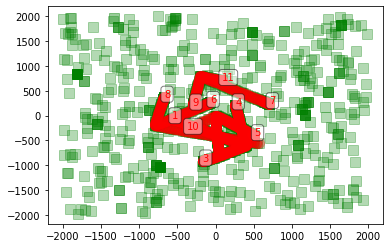

In [11]:
%matplotlib inline
from IPython.display import HTML
from matplotlib import animation, rc
from smrt.visualizer.gmphd import animate2d_prediction

anim = animate2d_prediction(observation=observations, truth=truth)
HTML(anim.to_html5_video())

## Save generated synthetic data to folder

Here, we save the generated synthetic data as checkpoint to local folder for fast load.

In [12]:
import os

chkpt_dir = '../data/synthetic_2d'
chkpt_filename = os.path.join(chkpt_dir, 'synthetic_2d.npz')

In [13]:
# Save to file
os.makedirs(chkpt_dir, exist_ok=True)
data = {
  'truth': truth,
  'observations': observations
}
np.savez(chkpt_filename, **data)

In [15]:
# Load from file
data = np.load(chkpt_filename, allow_pickle=True)
# Note: Truth is a dictionary, thus we need .item()
truth = data['truth'].item()
observations = data['observations']

# Part II: GM-PHD Filter

Probability Hypothesis Density (PHD) filter is a first order moment approximation of a multi-target Bayes filter, originally proposed by Mahler [[1]](#cite-1).
Vo and Ma [[2]](#cite-2) proposed a closed-form solution for the PHD filter by representing PHD in the form of a Gaussian mixture, hence the name GM-PHD filter.

In this section, I apply the GM-PHD filter to the target location observations synthesized in **Part I**, and evaluate the performance of how well the GM-PHD filter tracks multiple targets given the synthetic data.

## GM-PHD Filter Equations

The GM-PHD filter is composed of a predictor and a corrector.

### Predictor

At time step $k$, provided with the multitarget PHD at previous time step $k-1$, the predictor estimates the multi-target PHD at current time step based on the dynamic model of each target.
During the prediction, the predictor needs to include the birth of new targets, the death of existing targets and the dynamics (state update) of existing and alive targets.
As a result, the posterior multitarget PHD of the predictor is composed of the birth PHD (representing the new targets), and an integral of existing targets with the dynamic model (representing the state update of existing targets) attenuated by the persistance probability (representing the likelihood of the death of existing targets), as shown in the equation below.

\begin{equation}
D_{k|k-1}(\mathbf{x}) = D_{b}(\mathbf{x}) + p_s \cdot \int f(\mathbf{x}|\mathbf{x}') D_{k-1}(\mathbf{x}') \delta \mathbf{x}' 
\end{equation}

In the above equation, $D_{k|k-1}(\mathbf{x})$ is the posterior PHD estimated by the predictor based on the dynamic model; $p_s$ is the target persistence probability; $f(\mathbf{x}|\mathbf{x}')$ is the dynamic model that predicts the next state based on current state of a target.
If $f(\mathbf{x}|\mathbf{x}')$ is a linear Gaussian model as introduced in Part I, and multitarget PHD of time step $k-1$ is in the form of a Gaussian mixture, the posterior PHD of the predictor is in the form of a Gaussian mixture as well.

To put the predictor mathematically, given

\begin{equation}
D_{k-1}(\mathbf{x}) = \sum_{i=1}^{J_{k-1}} w_{k-1}^{(i)} \mathcal{N}(\mathbf{x}; \mathbf{m}_{k-1}^{(i)}, \mathbf{P}_{k-1}^{(i)})
\end{equation}

, the dynamic model

\begin{equation}
f(\mathbf{x}|\mathbf{x}') = \mathcal{N}(\mathbf{x}; \mathbf{F} \cdot \mathbf{x}', \mathbf{Q})
\end{equation}

, and the birth PHD

\begin{equation}
D_{b}(\mathbf{x}) = \sum_{i=1}^{J_b} w_{b}^{(i)} \mathcal{N}(\mathbf{x}; \mathbf{m}_{b}^{(i)}, \mathbf{P}_{b}^{(i)})
\end{equation}

the posterior PHD of the predictor at time step $k$ (based on the PHD at time step $k-1$)

\begin{equation}
D_{k|k-1}(\mathbf{x}) = \sum_{i=1}^{J_b} w_{b}^{(i)} \mathcal{N}\left(\mathbf{x}; \mathbf{m}_{b}^{(i)}, P_{b}^{(i)}\right) + p_s \cdot \sum_{i=1}^{J_{k-1}} w_{k-1}^{(i)} \mathcal{N}\left(\mathbf{x}; \mathbf{F} \cdot \mathbf{m}_{k-1}^{(i)}, \left(\mathbf{Q} + \mathbf{F} \mathbf{P}_{k-1}^{(i)}\mathbf{F}^T\right)\right)
\end{equation}

### Corrector

Based on the observation of target positions at time step $k$, denoted $Z_{k}$, the predicted PHD $D_{k|k-1}(\mathbf{x})$ needs to be corrected, hence the name corrector.
In the corrector process, the equation involves the measurement model of existing targets, the probability that a target is not detected and the clutter process model.

As a result, the corrector equation is composed of two parts as shown in the equation below.
The first part is the residule of predicted PHD conditioned by the probability that the target is not detected ($1-p_d$).
The second part is the predicted PHD corrected by the measurements of current time step.

\begin{equation}
D_{k}(\mathbf{x}) = (1-p_d) D_{k|k-1}(\mathbf{x}) + \sum_{\mathbf{z}\in Z_k} \frac{p_d f(\mathbf{z}|\mathbf{x})D_{k|k-1}(\mathbf{x})}{\lambda_c c(\mathbf{z}) + \int p_d f(\mathbf{z}|\mathbf{x}')D_{k|k-1}(\mathbf{x}')\delta\mathbf{x}'}
\end{equation}

In the above equation, $p_d$ is the target detection probability; $Z_k$ is the target location measurements at time step $k$; $f(\mathbf{z}|\mathbf{x})$ is the measurement model represented by the conditional probability of getting a location measurement $\mathbf{z}$ given the target state $\mathbf{x}$; $\lambda_c$ is the Poisson parameter of the clutter process; $c(\mathbf{z})$ is the spacial distribution density of the clutter process.

If $D_{k|k-1}(\mathbf{x})$ is in the form of a Gaussian mixture and the dynamic model $f(\mathbf{z}|\mathbf{x})$ is a linear Gaussian model, the posterior PHD $D_k(\mathbf{x})$ is in the form of a Gaussian mixture as well.
However, the computation of the corrector is much more complicated compared to the predictor.
Here, I lay out the result as follows.

Given the multitarget PHD predicted by the predictor

\begin{equation}
D_{k|k-1}(\mathbf{x}) = \sum_{i=1}^{J_{k|k-1}} w_{k|k-1}^{(i)} \mathcal{N}\left(\mathbf{x}; \mathbf{m}_{k|k-1}^{(i)}, \mathbf{P}_{k|k-1}^{(i)}\right)
\end{equation}

, the linear Gaussian measurement model

\begin{equation}
f(\mathbf{z}|\mathbf{x}) = \mathcal{N}\left(\mathbf{z}; \mathbf{H}\cdot\mathbf{x}, \mathbf{R}\right)
\end{equation}

, the posterior PHD of time step $k$ is

\begin{equation}
D_k(\mathbf{x}) = (1 - p_d) \sum_{i=1}^{J_{k|k-1}} w_{k|k-1}^{(i)} \mathcal{N}\left(\mathbf{x}; \mathbf{m}_{k|k-1}^{(i)}, \mathbf{P}_{k|k-1}^{(i)}\right) + \sum_{\mathbf{z}\in Z_k} \sum_{i=1}^{J_{k|k-1}} w_{k}^{(i)}(\mathbf{z}) \mathcal{N}\left(\mathbf{x}; \mathbf{m}_{k}^{(i)}(\mathbf{z}), \mathbf{P}_{k}^{(i)}\right)
\end{equation}

, where

\begin{equation}
w_k^{(i)}(\mathbf{z}) = \frac{p_d w_{k|k-1}^{(i)}q_k^{(i)}(\mathbf{z})}{\lambda_c c(\mathbf{z}) + p_d \sum_{j=1}^{J_{k|k-1}} w_{k|k-1}^{(j)}q_k^{(j)}(\mathbf{z})}
\end{equation}

\begin{equation}
q_k^{(i)}(\mathbf{z}) = \mathcal{N}\left(\mathbf{z}; \mathbf{H} \cdot \mathbf{m}_{k|k-1}^{(i)}, \mathbf{R}+\mathbf{H}\mathbf{P}_{k|k-1}^{(i)}\mathbf{H}^T\right)
\end{equation}

\begin{equation}
\mathbf{m}_k^{(i)}(\mathbf{z}) = \mathbf{m}_{k|k-1}^{(i)} + \mathbf{K}_k^{(i)}\left(\mathbf{z}-\mathbf{H}\mathbf{m}_{k|k-1}^{(i)}\right)
\end{equation}

\begin{equation}
\mathbf{P}_k^{(i)} = \left(\mathbf{I}-\mathbf{K}_k^{(i)}\mathbf{H}\right)\mathbf{P}_{k|k-1}^{(i)}
\end{equation}

\begin{equation}
\mathbf{K}_k^{(i)} = \mathbf{P}_{k|k-1}^{(i)}\mathbf{H}^T\left(\mathbf{H}\mathbf{P}_{k|k-1}^{(i)}\mathbf{H}^T + \mathbf{R}\right)^{-1}
\end{equation}


In [16]:
birth_weights = np.array([0.03, 0.03, 0.03, 0.03], dtype=np.float)
birth_means = np.array([
  [0., 0., 0., 0.],
  [400., -600., 0., 0.],
  [-800., -200., 0., 0.],
  [-200., 800., 0., 0.]
])
birth_covs = np.array([
  np.eye(4) * 100,
  np.eye(4) * 100,
  np.eye(4) * 100,
  np.eye(4) * 100
], dtype=np.float)

p_s = 0.9

model = CvMTGM_ID_Model(
    n_visible=n_visible,
    v_stddev=v_cov_std,
    m_stddev=r_cov_std,
    birth=(birth_weights, birth_means, birth_covs),
    p_d=p_d,
    p_s=p_s,
    clutter_lam=clutter_lam,
    clutter_c=clutter_c
)

In [17]:
# Initial weights, means and covariance of Gaussian mixture
gm_weights = np.zeros((0,))
gm_means = np.zeros((0, 4))
gm_covs = np.zeros((0, 4, 4))

# Records
gm_phds = []

# Start running the GM-PHD filter based on the observations
n_obs = len(observations)
for k in range(n_obs):
    # Call the filter process
    gm_weights, gm_means, gm_covs = model.call((gm_weights, gm_means, gm_covs, observations[k]))
    # Only keep the top few Gaussian components
    gm_weights, gm_means, gm_covs = model.gm_truncate(gm_weights, gm_means, gm_covs, 1000)
    # Clutter GMs
    gm_weights, gm_means, gm_covs = model.gm_id_cluster(gm_weights, gm_means, gm_covs)
    # Save them
    gm_phds.append((np.copy(gm_weights), np.copy(gm_means), np.copy(gm_covs)))

In [18]:
def target_state_estimation(gm_weights, gm_means):
    track_indexes = {}
    n_gc = gm_weights.shape[0]
    # Group Gaussian components in each track
    for i in range(n_gc):
        track_id = int(round(gm_means[i, -1]))
        if track_id in track_indexes:
            track_indexes[track_id].append(i)
        else:
            track_indexes[track_id] = [i]
    # Estimate state of each target
    n_tracks = len(track_indexes)
    track_states = np.zeros((n_tracks, 5), dtype=np.float)
    track_weights = np.zeros((n_tracks), dtype=np.float)
    for j, track_id in enumerate(track_indexes):
        track_state = np.zeros((5,), dtype=np.float)
        track_weight = 0.
        for i in track_indexes[track_id]:
            track_weight += gm_weights[i]
            track_state += gm_weights[i] * gm_means[i, :]
        track_weights[j] = track_weight
        track_states[j, :] = track_state / track_weight
    return track_states, track_weights

def print_tracks(truth, prediction, prediction_weights):
    n_truth = truth.shape[0]
    n_prediction = prediction.shape[0]
    print("Total targets: %d" % n_truth)
    for i in range(n_truth):
        print("\t[%d]: %.3f %.3f" % (
            int(round(truth[i, -1])), truth[i, 0], truth[i, 1]
        ))
    print("Predicted targets: %d" % n_prediction)
    for i in range(n_prediction):
        print("\t[%d]: %.3f %.3f confidence %.3f" % (
            int(round(prediction[i, -1])), prediction[i, 0], prediction[i, 1],
            prediction_weights[i]
        ))

In [19]:
for k in range(4):
    print("--- Step %d ---" % k)
    gm_weights, gm_means, gm_covs = gm_phds[k]
    track_states, track_weights = target_state_estimation(gm_weights, gm_means)
    print_tracks(truth['locations'][k], track_states, track_weights)
    print("")

--- Step 0 ---
Total targets: 0
Predicted targets: 1
	[0]: -150.000 0.000 confidence 0.011

--- Step 1 ---
Total targets: 3
	[0]: 0.000 0.000
	[1]: 400.000 -600.000
	[2]: -800.000 -200.000
Predicted targets: 3
	[1]: -5.133 -0.377 confidence 0.980
	[3]: 398.566 -599.507 confidence 0.983
	[2]: -800.918 -199.578 confidence 0.978

--- Step 2 ---
Total targets: 3
	[0]: -0.025 -10.004
	[1]: 389.934 -595.017
	[2]: -779.999 -204.989
Predicted targets: 4
	[2]: -768.673 -207.569 confidence 1.045
	[3]: 377.058 -590.061 confidence 1.053
	[1]: 1.803 -11.216 confidence 1.060
	[0]: -130.370 -268.306 confidence 0.110

--- Step 3 ---
Total targets: 3
	[0]: -0.097 -20.095
	[1]: 379.805 -590.066
	[2]: -760.008 -210.039
Predicted targets: 4
	[2]: -742.368 -213.578 confidence 1.092
	[3]: 368.346 -581.312 confidence 1.090
	[1]: 4.647 -23.185 confidence 1.085
	[0]: -47.955 -168.874 confidence 0.037



In [20]:
# Save computed GM-PHDs to npz file
data = {'gm_phds': gm_phds}
np.savez('./gm_phds.npz', **data)

In [22]:
data = np.load('./gm_phds.npz', allow_pickle=True)
gm_phds = data['gm_phds']
n_steps = gm_phds.shape[0]

In [23]:
prediction = {
  'locations': [],
  'targets': []
}

# Generate proper prediction and truth structure
valid_tracks = set()
for k in range(n_steps):
  gm_weights = gm_phds[k][0]
  gm_means = gm_phds[k][1]
  gm_covs = gm_phds[k][2]
  track_states, track_weights = target_state_estimation(gm_weights, gm_means)
  num_tracks = track_states.shape[0]
  valid_track_ind = []
  for t_id in range(num_tracks):
    track_id = int(round(track_states[t_id, -1]))
    if track_id != 0 and track_weights[t_id] >= 0.5:
      valid_tracks.add(track_id)
    if track_id in valid_tracks:
      valid_track_ind.append(t_id)
  track_locations = np.zeros((len(valid_track_ind), 5), dtype=np.float)
  track_targets = np.zeros((len(valid_track_ind),), dtype=np.int)
  for i, t_id in enumerate(valid_track_ind):
    track_id = int(round(track_states[t_id, -1]))
    track_locations[i, :] = track_states[t_id, :]
    track_targets[i] = track_id
  prediction['locations'].append(track_locations)
  prediction['targets'].append(track_targets)

In [ ]:
from smrt.metrics import clear_metrics

In [ ]:
associations = clear_metrics.mot_hypothesis_association(truth, prediction, ndims=2, threshold=20)

In [ ]:
print(clear_metrics.mota_report(associations))
print(clear_metrics.mota_score(associations))

In [ ]:
anim = animate2d_prediction(prediction=prediction, observation=observations, truth=truth)
HTML(anim.to_html5_video())

# References

<span id="cite-1">[1] R. P. S. Mahler, **"Multitarget Bayes filtering via first-order multitarget moments"**, *IEEE Transactions on Aerospace and Electronic systems*, vol. 39, no. 4, pp. 1152-1178, 2003</span>

<span id="cite-2">[2] B.-N. Vo and W.-K. Ma, **"The Gaussian mixture probability hypothesis density filter"**, *IEEE Transactions on signal processing*, vol. 54, no. 11, pp. 4091-4104, 2006.</span>